# Lab 1

## Question 1

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os 
import statsmodels.api as sm
import powerlaw
import scipy.stats as stats

### Dataset

Perform general statistical analyses on the datasets.  Are the results expected ?Perform some sanity checks on the data.  Is the dataset free of visible problems ?

In [2]:
def get_all_files(directory):
    files = [f for f in os.listdir(directory) 
             if os.path.isfile(os.path.join(directory, f))]
    return files

In [3]:
files = get_all_files(os.path.join('data', 'SG'))

dfs = []

for file in files:
    df_small = pd.read_csv(os.path.join('data', 'SG', file), index_col = 0)
    dfs.append(df_small)
    break                   # < ----------------- remove this line to read all files
df = pd.concat(dfs)
df['ets'] = pd.to_datetime(df['ets'], format='%Y%m%d:%H:%M:%S.%f')
df.head()

,ets,etype,eprice,eqty,eside,bp0,bq0,ap0,aq0
0,2017-01-17 09:01:00.270164,A,45610,1400,B,46010,1066,46085,1445
1,2017-01-17 09:01:00.312121,A,46485,700,S,46010,1066,46085,1445
2,2017-01-17 09:01:00.358162,A,46000,124,B,46010,1066,46085,1445
3,2017-01-17 09:01:00.359972,A,45950,182,B,46010,1066,46085,1445
4,2017-01-17 09:01:00.360001,A,45970,22,B,46010,1066,46085,1445


In [4]:
file_path = "/Users/hugo/Downloads/Data 2/SG/SG_20170118.csv.gz"

df = pd.read_csv(file_path, index_col=0, compression='gzip')

df['ets'] = pd.to_datetime(df['ets'], format='%Y%m%d:%H:%M:%S.%f')

df.head()


FileNotFoundError: [Errno 2] No such file or directory: '/Users/hugo/Downloads/Data 2/SG/SG_20170118.csv.gz'

- A: add limit order
- T: Trade (takes the best price)
- M: Modification
- C: Cancel

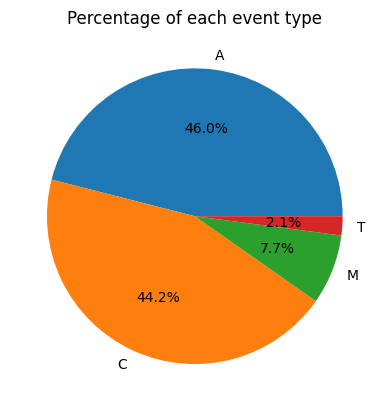

In [ ]:
plt.title("Percentage of each event type")
plt.pie(df['etype'].value_counts() / len(df), labels=df['etype'].value_counts().index, autopct='%1.1f%%')
plt.show()

Only 2.1% of real match-making trades really taking place out of all of the placed orders !

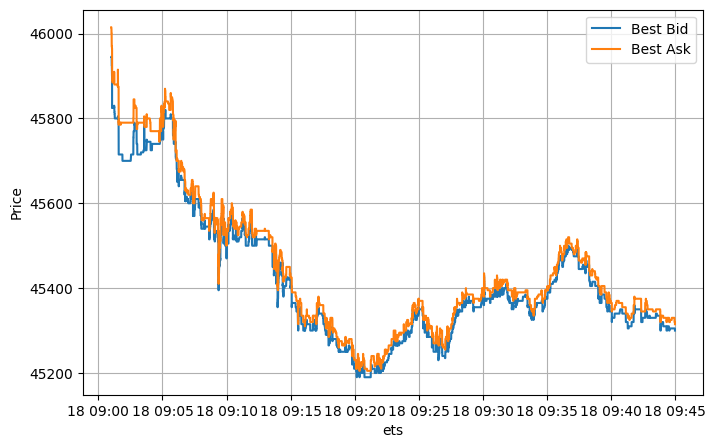

In [ ]:
df_2 = df.copy()
df_2.set_index('ets', inplace=True)
df_2.sort_index(inplace=True, ascending=True)

start_date = '2017-01-18 09:01:00.270164'
end_date = '2017-01-18 09:45:00.00'

plt.figure(figsize=(8, 5))
sns.lineplot(data=df_2[start_date:end_date], x='ets', y='bp0', label="Best Bid")
sns.lineplot(data=df_2[start_date:end_date], x='ets', y='ap0', label="Best Ask")
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

#### Trade Volumes

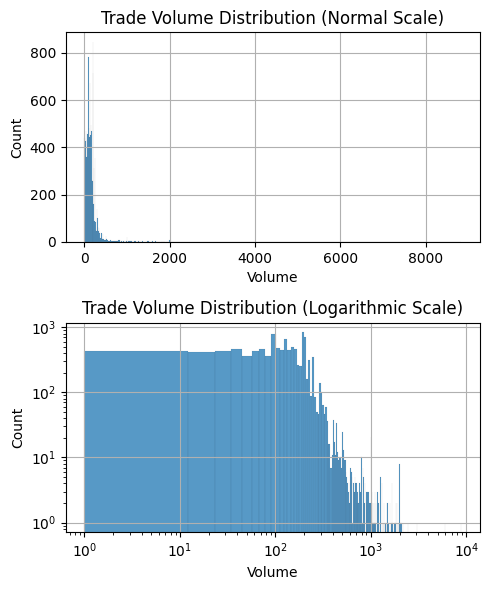

In [ ]:
# Filter the DataFrame for trades
df_trades = df[df['etype'] == 'T'].copy()

# Create subplots
fig, axes = plt.subplots(2, 1, figsize=(5, 6))

# Normal scale plot
sns.histplot(df_trades, x='eqty', kde=False, ax=axes[0])
axes[0].set_title('Trade Volume Distribution (Normal Scale)')
axes[0].set_xlabel('Volume')
axes[0].grid()

# Logarithmic scale plot
sns.histplot(df_trades, x='eqty', kde=False, ax=axes[1])
axes[1].set_yscale('log')
axes[1].set_xscale('log')
axes[1].set_xlabel('Volume')
axes[1].set_title('Trade Volume Distribution (Logarithmic Scale)')
axes[1].grid()

plt.tight_layout()
plt.show()

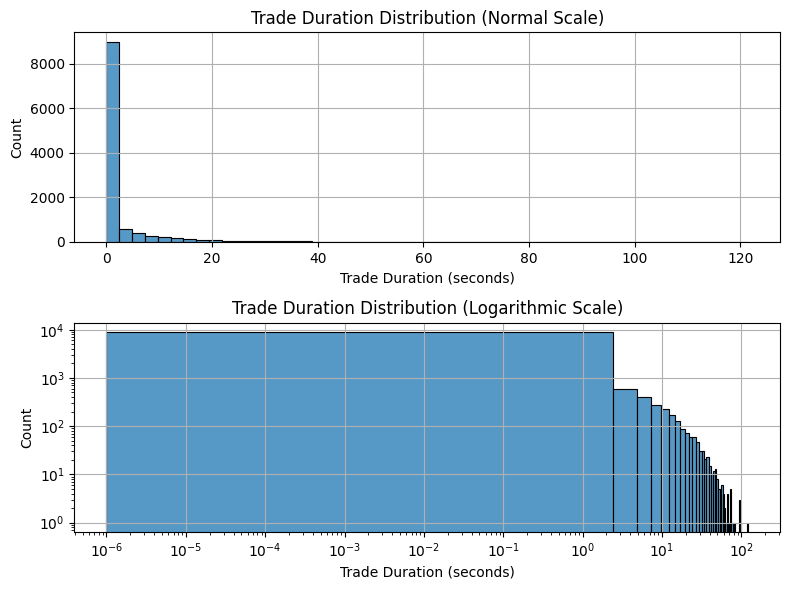

In [ ]:
df_trades = df[df['etype'] == 'T'].copy()
df_trades['trade_duration'] = df_trades['ets'].diff().dt.total_seconds()
df_trades = df_trades.iloc[1:]

fig, axes = plt.subplots(2, 1, figsize=(8, 6))

sns.histplot(df_trades, x='trade_duration', kde=False, bins=50, ax=axes[0])
axes[0].set_title('Trade Duration Distribution (Normal Scale)')
axes[0].set_xlabel('Trade Duration (seconds)')
axes[0].grid()

sns.histplot(df_trades, x='trade_duration', kde=False, bins=50, ax=axes[1])
axes[1].set_yscale('log')
axes[1].set_xscale('log')
axes[1].set_xlabel('Trade Duration (seconds)')
axes[1].set_title('Trade Duration Distribution (Logarithmic Scale)')
axes[1].grid()

plt.tight_layout()
plt.show()

Text(0, 0.5, 'Frequency (log scale)')

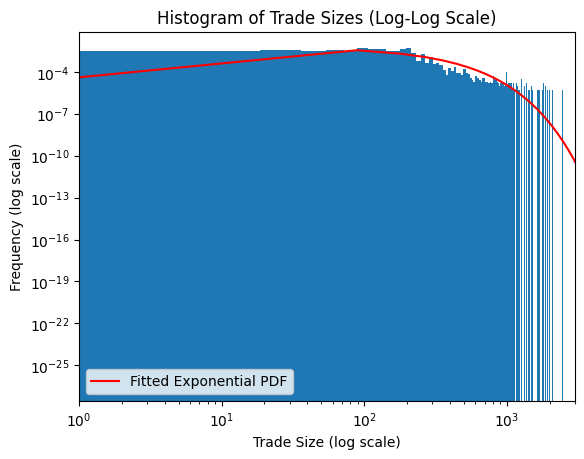

In [ ]:
# Fit an exponential distribution to the data
loc, scale = stats.expon.fit(df_trades['eqty'])

# Create a finer grid for plotting the fitted PDF
x_fit = np.linspace(0, np.max(df_trades['eqty']), 100)
y_fit = stats.expon.pdf(x_fit, loc=loc, scale=scale)

# Plot the original data and the fitted PDF
plt.hist(df_trades["eqty"], bins=500, density=True)
plt.plot(x_fit, y_fit, 'r-', label='Fitted Exponential PDF')
plt.legend()
plt.xlim(1, 3000)
plt.xscale('log')
plt.yscale('log')
plt.title('Histogram of Trade Sizes (Log-Log Scale)')
plt.xlabel('Trade Size (log scale)')
plt.ylabel('Frequency (log scale)')

Calculating best minimal value for power law fit


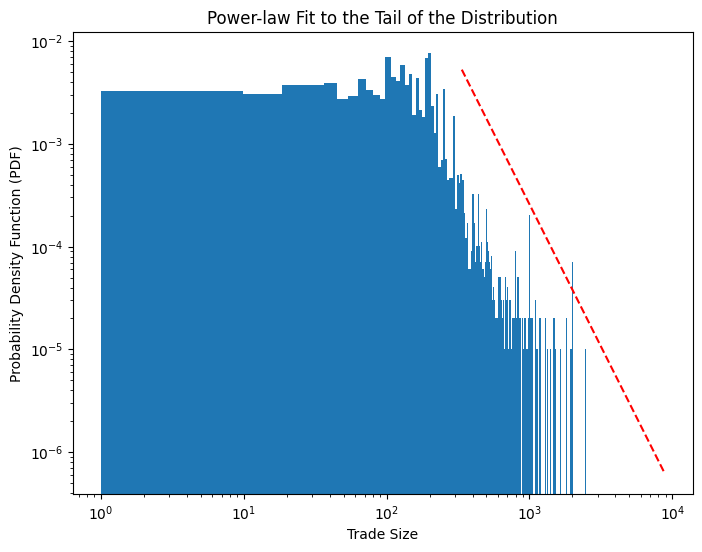

Power-law alpha: 2.7625888116205477
Power-law xmin: 336.0


In [ ]:
# Use the powerlaw package to fit the data
fit = powerlaw.Fit(df_trades["eqty"])

plt.figure(figsize=(8, 6))

alpha = fit.power_law.alpha
xmin = fit.power_law.xmin
plt.hist(df_trades["eqty"], bins=1000, density=True)
fit.power_law.plot_pdf(color='r', linestyle='--')

plt.xlabel('Trade Size')
plt.ylabel('Probability Density Function (PDF)')
plt.title('Power-law Fit to the Tail of the Distribution')
plt.show()

# Print the estimated parameters
print(f"Power-law alpha: {alpha}")
print(f"Power-law xmin: {xmin}")

#### Trading activity and volatility

### Mid-Price and Weighted Mid-Price Visualization

The mid-price is defined as :

$$Mid\text{-}Price = \frac{a(t) + b(t)}{2}$$

The **weighted mid-price** is defined as:

$$W_{mid-price} = \frac{a(t)q^B(t) + b(t)q^A(t)}{q^B(t) + q^A(t)}$$

In [ ]:
# bp0, bq0,	ap0, aq0
# best bid price, best bid quantity, best ask price, best ask quantity

df['mid_price'] = (df['bp0'] + df['ap0']) / 2

df['weighted_mid_price'] = ((df['bp0'] * df['aq0']) + (df['ap0'] * df['bq0'])) / (df['bq0'] + df['aq0'])

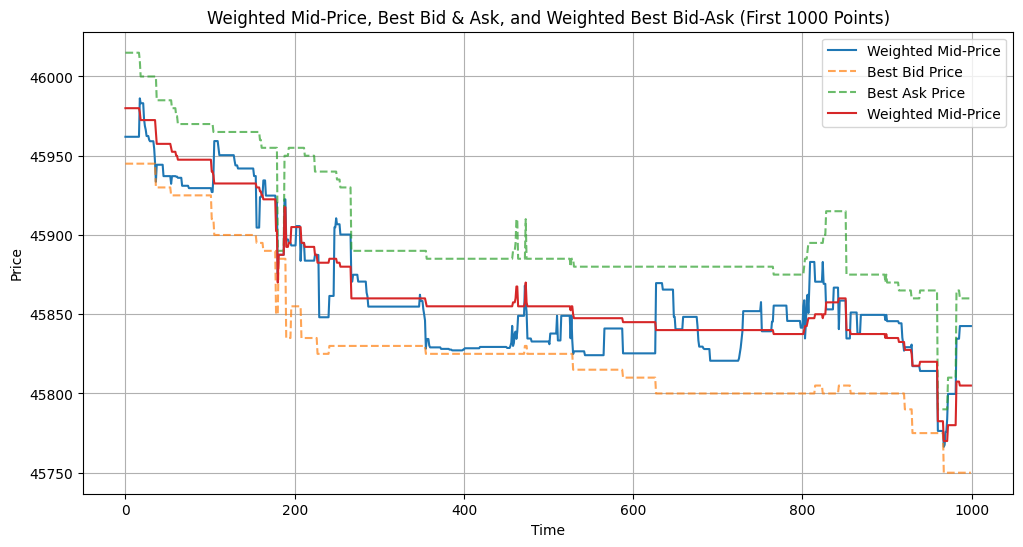

In [ ]:
df_subset = df.iloc[:1000]

plt.figure(figsize=(12, 6))
df_subset['weighted_mid_price'].plot(label="Weighted Mid-Price", linestyle='-', linewidth=1.5)
df_subset['bp0'].plot(label="Best Bid Price", linestyle='--', alpha=0.7)
df_subset['ap0'].plot(label="Best Ask Price", linestyle='--', alpha=0.7)
df_subset['mid_price'].plot(label="Weighted Mid-Price", linestyle='-', linewidth=1.5)

plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Weighted Mid-Price, Best Bid & Ask, and Weighted Best Bid-Ask (First 1000 Points)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
df['tick_size_bid'] = df['bp0'].diff().abs()
df['tick_size_ask'] = df['ap0'].diff().abs()

tick_sizes = pd.concat([df['tick_size_bid'], df['tick_size_ask']]).replace(0, np.nan).dropna()

measured_tick_size = tick_sizes.min()

print(f'the smallest tick size occuring on the dataset is in line with the official tick size : {measured_tick_size} for stocks between 9.99 and 50 Euros as outlined in the course')

the smallest tick size occuring on the dataset is in line with the official tick size : 5.0 for stocks between 9.99 and 50 Euros as outlined in the course


### Log-Returns High Frequency

In [ ]:
df_trades_min = df.copy()

df_trades_min['ets'] = pd.to_datetime(df_trades_min['ets'])

df_trades_min.set_index('ets', inplace=True)

df_trades_min_resampled = df_trades_min.copy()

df_trades_min_resampled = df_trades_min['eprice'].resample('min').last()

df_trades_min_resampled

ets
2017-01-18 09:01:00    45655
2017-01-18 09:02:00    45620
2017-01-18 09:03:00    46120
2017-01-18 09:04:00    45835
2017-01-18 09:05:00    45660
                       ...  
2017-01-18 17:25:00    47000
2017-01-18 17:26:00    45435
2017-01-18 17:27:00    45410
2017-01-18 17:28:00    45430
2017-01-18 17:29:00    45430
Freq: min, Name: eprice, Length: 509, dtype: int64

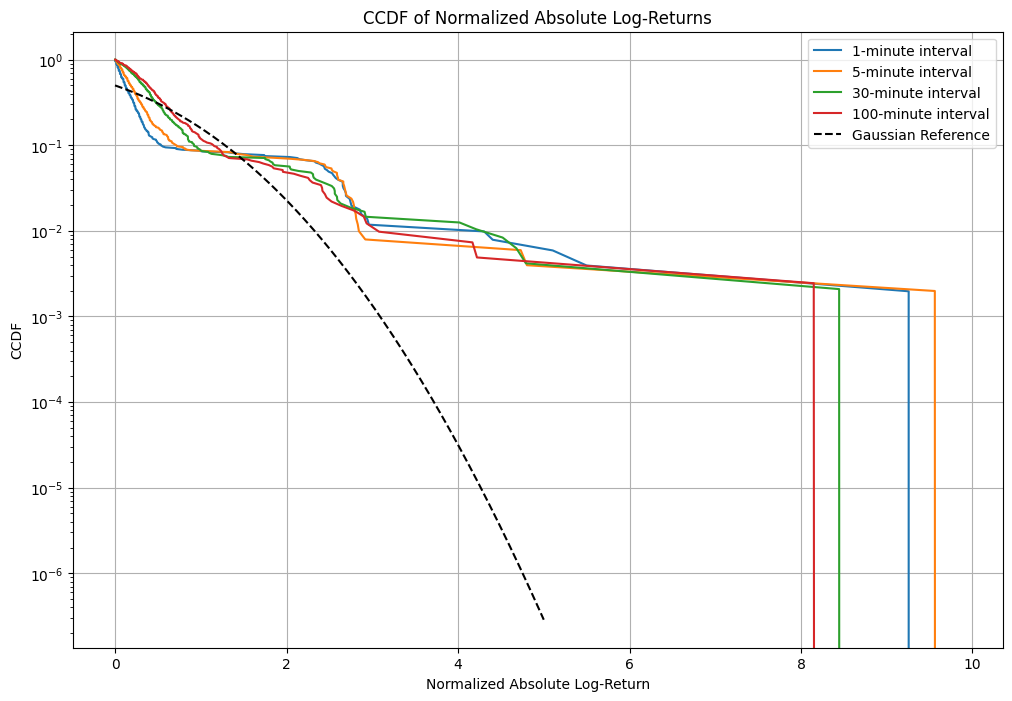

In [ ]:
plt.figure(figsize=(12, 8))

frequencies = [1, 5, 30, 100]

for freq in frequencies:
    log_ret = np.log(df_trades_min_resampled / df_trades_min_resampled.shift(freq)).dropna()

    normalized_abs_log_ret = np.abs((log_ret - np.mean(log_ret)) / np.std(log_ret))
    
    sorted_data = np.sort(normalized_abs_log_ret)
    ccdf = 1. - np.arange(1, len(sorted_data)+1) / len(sorted_data)
    
    plt.semilogy(sorted_data, ccdf, label=f'{freq}-minute interval')

gaussian_x = np.linspace(0, 5, 1000)
gaussian_ccdf = 1. - stats.norm.cdf(gaussian_x)
plt.semilogy(gaussian_x, gaussian_ccdf, 'k--', label='Gaussian Reference')

plt.title('CCDF of Normalized Absolute Log-Returns')
plt.xlabel('Normalized Absolute Log-Return')
plt.ylabel('CCDF')
plt.legend()
plt.grid(True)
plt.show()

We see that we are totally out of the gaussian scope and more interestingly : the frequency at which we look at the log-returns matter, the faster the frequency the less gaussian in principle. Here we see that on a specific day : we can find a counter-example : the 5 mins mark return compared to the 1 minute.

### 5. Volatility in high-frequency

In [ ]:
df_trades = df.copy()
df_trades['ets'] = pd.to_datetime(df_trades['ets'])

df_trades.set_index('ets', inplace=True)

df_trades_resampled = df_trades['eprice'].resample('S').last()
df_trades_resampled = df_trades_resampled.fillna(method="ffill")
df_trades_resampled

/var/folders/nd/lbp9nypd0l328jm0b27jr8c00000gn/T/ipykernel_2318/47223661.py:6: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  df_trades_resampled = df_trades['eprice'].resample('S').last()
/var/folders/nd/lbp9nypd0l328jm0b27jr8c00000gn/T/ipykernel_2318/47223661.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_trades_resampled = df_trades_resampled.fillna(method="ffill")


ets
2017-01-18 09:01:00    46045.0
2017-01-18 09:01:01    45910.0
2017-01-18 09:01:02    45820.0
2017-01-18 09:01:03    46055.0
2017-01-18 09:01:04    45970.0
                        ...   
2017-01-18 17:29:55    45370.0
2017-01-18 17:29:56    45760.0
2017-01-18 17:29:57    45425.0
2017-01-18 17:29:58    46000.0
2017-01-18 17:29:59    45400.0
Freq: s, Name: eprice, Length: 30540, dtype: float64

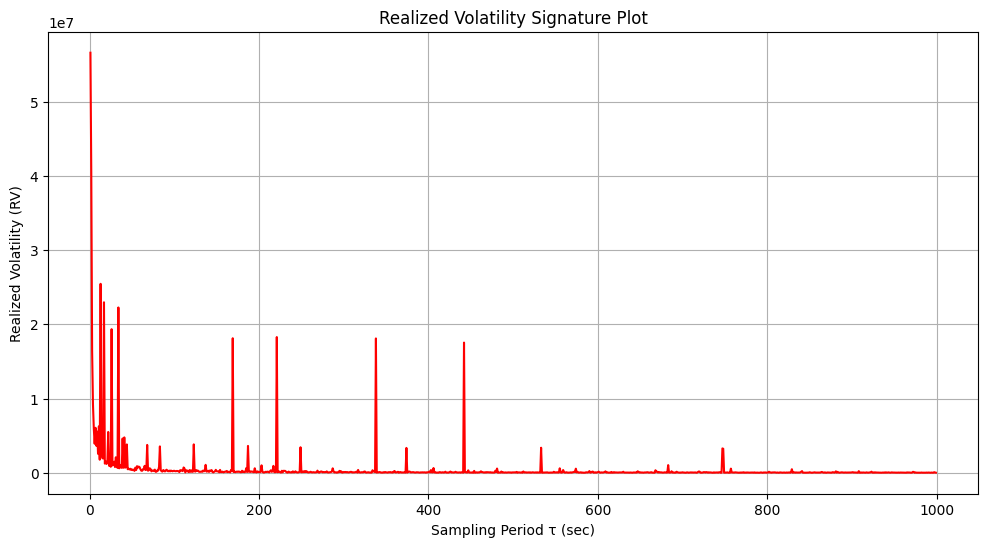

In [ ]:
def realized_volatility(prices, tau):
    res = 0
    for i in range(1, int(len(prices)/tau)):
        res += (prices[i*tau] - prices[(i-1)*tau])**2
    return res/100
    

sampling_periods = np.arange(1, 1000, 1)

rv_estimates = [realized_volatility(df_trades_resampled.values, tau) for tau in sampling_periods]

plt.figure(figsize=(12, 6))
plt.plot(sampling_periods, rv_estimates, color='red')
plt.title('Realized Volatility Signature Plot')
plt.xlabel('Sampling Period τ (sec)')
plt.ylabel('Realized Volatility (RV)')
plt.grid(True)
plt.show()

## Spread

In [ ]:
df['spread'] = df['ap0'] - df['bp0']

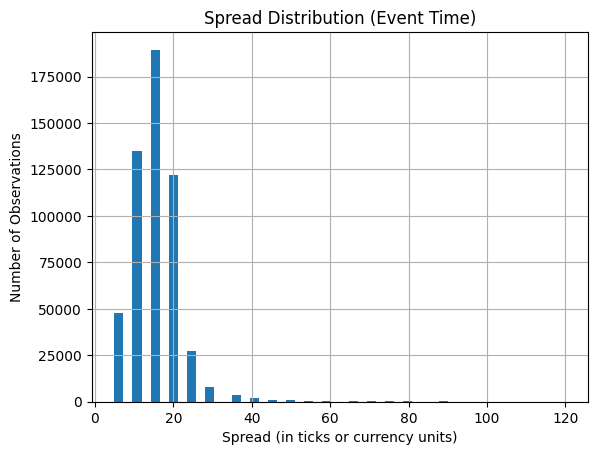

In [ ]:
plt.figure()
df['spread'].hist(bins=50)
plt.title("Spread Distribution (Event Time)")
plt.xlabel("Spread (in ticks or currency units)")
plt.ylabel("Number of Observations")
plt.show()

In [ ]:
spread_counts = df['spread'].value_counts().sort_index()
spread_freq = spread_counts / spread_counts.sum()
print(spread_freq.head(10))

spread
5     0.088564
10    0.249884
15    0.351210
20    0.226561
25    0.050520
30    0.015160
35    0.006527
40    0.003612
45    0.002043
50    0.001265
Name: count, dtype: float64


In [ ]:
df.index = pd.to_datetime(df.index)  # Ensure index is datetime
df['ts_next'] = df.index.to_series().shift(-1)  # Shift index to get next timestamp
df['delta'] = (df['ts_next'] - df.index.to_series()).dt.total_seconds()  # Compute time difference

# Drop last row where 'delta' is NaN (because there's no next timestamp)
df.dropna(subset=['delta'], inplace=True)


In [ ]:
# Group by the spread and sum up the seconds
spread_time_sums = df.groupby('spread')['delta'].sum()

# Total time across all spreads
total_time = spread_time_sums.sum()

# Fraction of total clock time that each spread was active
spread_freq_calendar = spread_time_sums / total_time


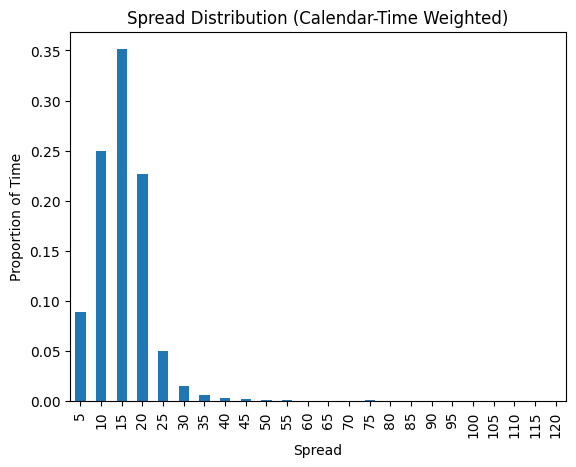

In [ ]:
plt.figure()
spread_freq_calendar.plot(kind='bar')
plt.title("Spread Distribution (Calendar-Time Weighted)")
plt.xlabel("Spread")
plt.ylabel("Proportion of Time")
plt.show()


4. Interpretation

Large-tick vs. Small-tick
If most quotes have a spread of exactly 1 tick (and occasionally 2 ticks), that strongly indicates a large-tick stock.
If the spread takes many distinct values (3, 4, 5, … ticks) and moves among them, that’s more typical of a small-tick stock.
Event time vs. Calendar time
In event time, each update/row is counted equally. This distribution can be skewed by brief, rapid quote updates.
In calendar time, a spread that persists for a long period (even if no new events occur) is given a proportionate weight.
In many real-world large-tick stocks, you’ll see the spread pinned at 1 tick for a large fraction of both the events and the time. However, the two distributions can differ because the market might “flicker” among 1–2 ticks frequently in busy periods, but sit quietly at 1 tick for long intervals in slower periods, or vice versa.

Ultimately, comparing these two distributions shows whether the spread changes often but briefly (event time distribution might differ a lot from calendar time), or whether it tends to “stick” at a certain level for long durations (leading to a large chunk of total clock time at that level).

In [ ]:
df['mid'] = (df['bp0'] + df['ap0']) / 2
df['IB'] = df['bq0'] / (df['bq0'] + df['aq0'])

In [ ]:
df['mid_future'] = df['mid'].shift(-1)  # next event's mid
df['log_ret_next'] = np.log(df['mid_future']) - np.log(df['mid'])

Trade signs